<a href="https://colab.research.google.com/github/upunaprosk/Feature_selection-based-on-IFS/blob/main/IFS_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intuitionistic fuzzy sets theory

An IFS \\(A\\) in \\(X\\) is given by \\(A = \{<x, \mu_A(x), \nu_A(x)>|x\in X\}\\), where \\(\mu_A,\nu_A : X \Rightarrow [0,1]\\) with the condition \\(0\leq\mu_A(x) +\nu_A(x)\leq 1\\), where \\(\mu_A(x), \nu_A(x)\\) - are membership and a nonmembership function respectively. The third function IFS is defined by is a hesitation margin or the intuitionistic fuzzy index \\(\pi_A(x) = 1-\mu_A(x)-\nu_A(x)\\) that expresses the lack of knowledge of whether \\(x\\) belongs to \\(A\\) or not.  

The method demonstrated in [1] refers to feature selection (not attribute selection as the title says) in the binary classification problem.  In that notebook the method is fully replicated on the dataset that the authors also used.  
The steps of the method:  
1) Computing relative frequencies of each feature's attributes;  
2) Mass assignment for each attribute's value for each feature;  
3) Building IFS triplet for each attribute;  
4) Computing average triplet for each feature and determing feature importance.  

Restrictions of the method introduced:  
1) binary target feature;  
2) categorical features;  
3) special characteristics that defined in [Analysis of the results](#results).


In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from google.colab import files
uploaded = files.upload() # Downloading 'SPECT.train.csv' 'SPECT.test.csv' from https://archive.ics.uci.edu/ml/machine-learning-databases/spect/

Saving SPECT.test.csv to SPECT.test.csv
Saving SPECT.train.csv to SPECT.train.csv


# Step one :: computing relative frequencies of each feature's attributes \\(p_i\\)



For each feature and attribute the quantity of appearence within postove and negative class is defined.  
Target feature - diagnosis (first column).  
The shape of the train dataset : (80,23). 
All the 22 features are binary ones.

In [ ]:
df = pd.read_csv('SPECT.train.csv', header=None)
columns = ['diagnosis']
columns.extend(['feature' + str(i) for i in range(1, len(df.columns))])
df.columns = columns
df.head()

,diagnosis,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22
0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1
2,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1
4,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0


In [ ]:
df.shape

(80, 23)

In [ ]:
arrays = [[1,1,0,0], [1,0,1,0]]
dd = pd.DataFrame(columns= pd.MultiIndex.from_arrays(arrays, names=('diagnosis', 'feature')))
dd.columns = pd.MultiIndex.from_arrays(arrays, names=('diagnosis', 'feature'))

In [ ]:
all_values = [(1, 0), (1, 1), (0, 0), (0, 1)] # tuple of all possible values
features = df.columns.tolist()[1:]
for i in features:
    datum = df.groupby(['diagnosis',i])[i].count().to_frame().transpose()
    if set(datum.columns.tolist()) != set(all_values):
        values = set(all_values).difference(set(datum.columns.tolist()))
        for i in values:
            datum[i] = 0
    dd = pd.concat([dd, datum])
display(dd)

0       1    
            0   1   0   1
feature1   29  11  22  18
feature2   37   3  30  10
feature3   34   6  25  15
feature4   36   4  27  13
feature5   30  10  26  14
feature6   37   3  33   7
feature7   35   5  24  16
feature8   36   4  22  18
feature9   36   4  29  11
feature10  32   8  25  15
feature11  37   3  27  13
feature12  35   5  25  15
feature13  35   5  17  23
feature14  36   4  28  12
feature15  39   1  35   5
feature16  39   1  27  13
feature17  40   0  32   8
feature18  40   0  34   6
feature19  35   5  30  10
feature20  35   5  27  13
feature21  36   4  25  15
feature22  33   7  21  19

In [ ]:
dfs = np.split(dd, [2], axis=1)
dfs[0] = dfs[0]/df[df['diagnosis'] == 1].shape[0]
dfs[1] = dfs[1]/df[df['diagnosis'] == 0].shape[0]

Frequencies of appearing \\((1, 0), (1, 1), (0, 0), (0, 1)\\), where first value - diagnosis, second value = feature value for each group

In [ ]:
new_data = dfs[0].join(dfs[1])
new_data.head()

0             1       
              0      1      0      1
feature1  0.725  0.275   0.55   0.45
feature2  0.925  0.075   0.75   0.25
feature3   0.85   0.15  0.625  0.375
feature4    0.9    0.1  0.675  0.325
feature5   0.75   0.25   0.65   0.35

# Step two and three :: Building IFS

## Step two
Firstly, for each attribute values (in case of the SPECT data there are 2 of them) \\(pos\\) and \\(neg\\) are computed.  
\\(pos_i|neg_i = |F|_i\cdot p_i + \sum_{i=1}^n (|F_k|-|F|_{k+1}|)\cdot p_k\\), where \\(|F|_i  = |\{x \in \Lambda | P(x) \geq p_i\}|\\), \\(0\leq p_{i+1} < p_i \leq 1 \\).  
So, to put in other words, for each feature attribute from the table of relative frequencies defined above there are four values: two values for positive and negative class. These values can be defined as \\(p_0^+(i), p_1^+(i)\\), same - for negative class, where \\(i\\) - feature's value and \\(0,1\\) are feature's values (attributes).  
For the mass assgnment (computing \\(pos\\) and \\(neg\\)) they have to be sorted first. After that the least frequency is multiplied by two as \\(|F_i| =2\\) beacause two values of frequency probabilities are greater or equal to it, and the other is assigned to one by the mass assignment property.  
That step is computed in ```votings``` function.
Example of input/output:  
Feature 1:  

```
temp = [((0, 0), 0.725), ((0, 1), 0.275), ((1, 0), 0.55), ((1, 1), 0.45)]
neg = votings(temp[2:]) = votings(((1, 0), 0.55), ((1, 1), 0.45)) = {1: 0.9, 0: 1}
```
```{1: 0.9, 0: 1}::   0.9 = 0.45 *2; 0: 1```
## Step three
Secondly, based on obtained \\(pos\\) and \\(neg\\) values an IFS triplet is obtained and the corresponding values of the dataset are replaced with them for further averaging in step four. The triplet's values are computed as follows: 

1) \\(\pi(i) = pos(i)+neg(i)-1\\);  
2) \\(\mu = pos(i)-\pi(i)\\);
3) \\(\nu = neg(i)-\pi(i)\\);


That part of computations is provided in ```computing_ifs``` function.

In [ ]:
# votings = |F|_i * p_i + |F|_i-|F|_{j+1} (from article Intuitionistic Fuzzy Set Functions, Mass Assignment Theory,
# Possibility Theory and Histograms) (list_of_objects: list) -> dict
def votings(list_of_objects: list) -> dict:


  ''' attr: list of pos or neg frequencies of values {0,1}
      returns: a dict of mu(i) for binary  values 
  '''
  myDict = {} 
  list_of_objects = sorted(list_of_objects, key=lambda tup: tup[1])
  for i in range(len(list_of_objects)):
      idx = 0
      for j in range(i):
          idx += list_of_objects[j][1]
      x = min(1, (len(list_of_objects)-i) * list_of_objects[i][1] + idx)
      myDict[list_of_objects[i][0][1]] = x
  return myDict

def compute_ifs(pos: dict, neg: dict) -> dict:
    res = {}
    for i in pos.keys():
        pi = max(0, pos[i] + neg[i] - 1)
        mu = max(0, pos[i] - pi)
        nu = max(0, neg[i] - pi)

        res[i] = np.array([pi,mu,nu]).round(5)
    return res
    
index = 0
df1 = df.astype(int)
for i in range(len(new_data)):
    temp = list(zip(new_data.iloc[[i],:].columns.tolist(), new_data.iloc[[i],:].values[0].tolist()))
    neg = votings(temp[2:])
    pos = votings(temp[:2])
    res = compute_ifs(pos,neg)
    df1[features[index]] = df1[features[index]].map(res)
    index += 1
df1.head()

,diagnosis,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22
0,1,"[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.0, 0.2, 0.65]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.1, 0.1, 0.8]","[0.0, 0.2, 0.55]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.25, 0.0, 0.75]","[0.0, 0.2, 0.6]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]"
1,1,"[1, 0, 0]","[1, 0, 0]","[0.05, 0.25, 0.7]","[0.0, 0.2, 0.65]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.1, 0.1, 0.8]","[0.0, 0.2, 0.55]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.25, 0.0, 0.75]","[0.0, 0.2, 0.6]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.3, 0.05, 0.65]"
2,1,"[0.45, 0.1, 0.45]","[1, 0, 0]","[0.05, 0.25, 0.7]","[1, 0, 0]","[0.2, 0.3, 0.5]","[1, 0, 0]","[1, 0, 0]","[0.1, 0.1, 0.8]","[1, 0, 0]","[0.15, 0.25, 0.6]","[1, 0, 0]","[1, 0, 0]","[0.25, 0.0, 0.75]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]"
3,1,"[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.0, 0.15, 0.65]","[1, 0, 0]","[0.85, 0.15, 0.0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.0, 0.25, 0.65]","[0.0, 0.2, 0.75]","[0.3, 0.05, 0.65]"
4,1,"[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.1, 0.1, 0.8]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[0.25, 0.0, 0.75]","[1, 0, 0]","[0.0, 0.05, 0.25]","[0.0, 0.05, 0.65]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]","[1, 0, 0]"


# Step four:: Computing feature importance

As defined in [1], feature importance of the feature \\(k\\) can be estimated by the following function: 

\\(f(A_k) = |1-\bar\pi_k|\cdot |\bar\mu_k-\bar\nu_k|\\)

In [ ]:
results = df1.loc[:, features].sum()/len(df)
result_ifs = pd.DataFrame({'Feature':results.index, 'list':results.values})
result_ifs ['π'] = result_ifs ['μ'] = result_ifs ['υ'] = result_ifs ['μ - υ'] = 0
result_ifs ['π']= result_ifs ['list'].apply(lambda x: x[0]) 
result_ifs ['μ']= result_ifs ['list'].apply(lambda x: x[1]) 
result_ifs ['υ']= result_ifs ['list'].apply(lambda x: x[2]) 
result_ifs = result_ifs.drop('list',axis = 1)
result_ifs['μ - υ'] = abs(result_ifs ['μ'] - result_ifs ['υ'])
result_ifs['|1- π|⋅|μ - υ|'] = abs(1 -result_ifs ['π']) * result_ifs ['μ - υ'] 
result_ifs = result_ifs.sort_values('|1- π|⋅|μ - υ|',ascending = False)
display(result_ifs)

,Feature,π,μ,υ,μ - υ,|1- π|⋅|μ - υ|
12,feature13,0.640000,0.097500,0.262500,0.165000,0.059400
7,feature8,0.752500,0.027500,0.220000,0.192500,0.047644
21,feature22,0.772500,0.016250,0.211250,0.195000,0.044363
6,feature7,0.750625,0.052500,0.196875,0.144375,0.036004
11,feature12,0.750000,0.062500,0.187500,0.125000,0.031250
20,feature21,0.762500,0.047500,0.178125,0.130625,0.031023
2,feature3,0.750625,0.065625,0.183750,0.118125,0.029457
0,feature1,0.800625,0.036250,0.163125,0.126875,0.025296
9,feature10,0.755625,0.071875,0.172500,0.100625,0.024590
3,feature4,0.787500,0.042500,0.138125,0.095625,0.020320


## Features' ranking

In [ ]:

fig = px.line(result_ifs.sort_values('|1- π|⋅|μ - υ|',ascending = False).reset_index(drop = True), x="Feature", y="|1- π|⋅|μ - υ|",labels={
                     "|1- π|⋅|μ - υ|": "Feature significance",
                 })
fig.show()

<a name="results"></a>
# Analysis of the results

The method may look fine, but the results obtained differ from the ones the authors of the article got [1], that is due to the following mass assignment's property: 
for each attribute firstly \\(pos\\) and \\(neg\\) are computed, then, the hesitation margin is computed by its definition [2]:  
 \\(\pi(x) = pos_x+neg_x-1\\),  
 but if take a deeper look in that definition: \\(pos_x(i) = 2\cdot p_x\text{ or }1\\), where \\(i\\) - is the feature's index, and \\(x\\) - attribute's value. 

Same for \\(neg_x(i)\\), and, the value \\(2\cdot p_x(i) + 2\cdot p_y(i)\\) can be, of course, less than one, thus, the hesitation margin can be below zero, the authors did not define the resolution of that problem and how to deal with it, so, the hesitaion margin can be negative. 

# Comparing results with the random forest results

In [ ]:
# Train/test splitting
df = pd.read_csv('SPECT.train.csv', header=None)
df_test = pd.read_csv('SPECT.test.csv', header=None)
columns = ['diagnosis']
columns.extend(['feature' + str(i) for i in range(1, len(df.columns))])
df.columns = columns
df_test.columns = columns
X_test = df_test.loc[:, columns[1:]].values
y_test = df_test.loc[:, columns[0]].values
X_train = df.loc[:, columns[1:]].values
y_train = df.loc[:, columns[0]].values
rf_model = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
print("train accuracy:",rf_model.score(X_train,y_train))
print("test accuracy:",rf_model.score(X_test,y_test))

train accuracy: 0.925
test accuracy: 0.7754010695187166


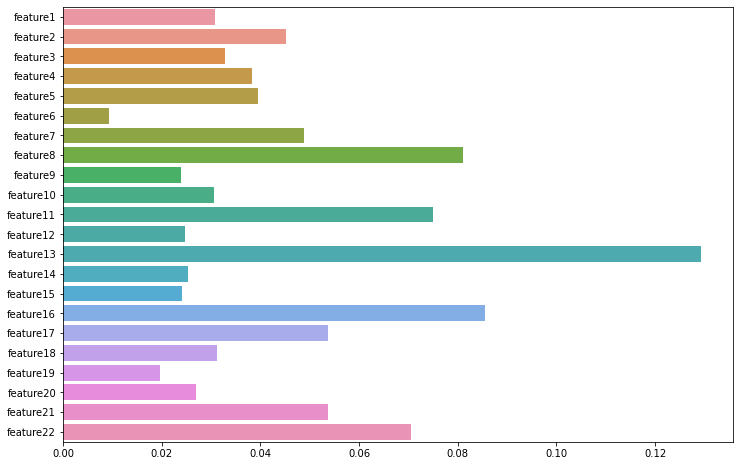

,Random_forest_feature_importance,IFS_indices,IFS_feature_importance
Random_forest_indices,,,
feature13,0.129259,feature13,0.059400
feature16,0.085561,feature8,0.047644
feature8,0.081060,feature22,0.044363
feature11,0.075056,feature7,0.036004
feature22,0.070569,feature12,0.031250
feature21,0.053696,feature21,0.031023
feature17,0.053638,feature3,0.029457
feature7,0.048743,feature1,0.025296
feature2,0.045214,feature10,0.024590


In [ ]:
#Feature Importance & selection
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_model.feature_importances_, y=df.columns[1:])
plt.show()
importance = pd.DataFrame(rf_model.feature_importances_, index = df.columns[1:], \
                          columns = ["Random_forest_feature_importance"]).sort_values("Random_forest_feature_importance", ascending = False)
importance.index.name = 'Random_forest_indices'
importance['IFS_indices'] = result_ifs['Feature'].values
importance['IFS_feature_importance'] = result_ifs['|1- π|⋅|μ - υ|'].values
importance.head(10)

In [ ]:
print('Cardinality of sets\' intersection of top ten features ranked:', len(set(importance['IFS_indices'][:10])&set(importance.index.tolist()[:10])))

Cardinality of sets' intersection of top ten features ranked: 5


In [ ]:
selected_ifs =  importance['IFS_indices'][:10]
selected_random_forest = importance.index.tolist()[:10]
selected_article = []
selected_article.extend(['feature' + str(i) for i in [13,8,21,22,16,3,20,10,1,7]])
X_test_rf = df_test.loc[:, selected_random_forest].values
X_train_rf = df.loc[:, selected_random_forest].values
X_test_ifs = df_test.loc[:, selected_ifs].values
X_train_ifs = df.loc[:, selected_ifs].values
X_test_art = df_test.loc[:, selected_article].values
X_train_art = df.loc[:, selected_article].values

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, f1_score, confusion_matrix
a = ('rf','ifs', 'art')
train_test = [(X_train_rf, X_test_rf ), (X_train_ifs, X_test_ifs), (X_train_art, X_test_art)]
results = dict()
for i in range(100):
  for j in zip(a, train_test):
    rf_model = RandomForestClassifier(n_estimators=10).fit(j[1][0], y_train)
    y_pred = rf_model.predict(j[1][1])
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f_one = f1_score(y_test, y_pred)
    k = results.get(j[0], 0)
    if type(k) == type(0):
      results[j[0]] = np.zeros((1,4))
    results[j[0]] += np.array([acc,rec,prec,f_one])

for i in results.keys():
  results[i]/=100
for i in results.keys():
  print(f'Average metrics for selection: {i}')
  for j,k in enumerate(['accuracy', 'recall', 'precision', 'f1-score']):
    print(k, results[i][:, j])
  print('*'*10)

Average metrics for selection: rf
accuracy [0.71989305]
recall [0.71046512]
precision [0.97942756]
f1-score [0.82291991]
**********
Average metrics for selection: ifs
accuracy [0.67994652]
recall [0.66610465]
precision [0.9793159]
f1-score [0.79267527]
**********
Average metrics for selection: art
accuracy [0.72855615]
recall [0.72284884]
precision [0.97589707]
f1-score [0.82923811]
**********


# Decision tree classifier

In [ ]:
dec_tree = DecisionTreeClassifier().fit(X_train,y_train)
print("train accuracy:",dec_tree.score(X_train,y_train))
print("test accuracy:",dec_tree.score(X_test,y_test))
dec_tree_preds = dec_tree.predict(X_test)
print(classification_report(y_test,dec_tree_preds))

train accuracy: 0.9375
test accuracy: 0.679144385026738
              precision    recall  f1-score   support

           0       0.17      0.80      0.29        15
           1       0.97      0.67      0.79       172

    accuracy                           0.68       187
   macro avg       0.57      0.73      0.54       187
weighted avg       0.91      0.68      0.75       187



In [ ]:
results = dict()
for i in range(100):
  for j in zip(a, train_test):
    rf_model = DecisionTreeClassifier().fit(j[1][0], y_train)
    y_pred = rf_model.predict(j[1][1])
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f_one = f1_score(y_test, y_pred)
    k = results.get(j[0], 0)
    if type(k) == type(0):
      results[j[0]] = np.zeros((1,4))
    results[j[0]] += np.array([acc,rec,prec,f_one])

for i in results.keys():
  results[i]/=100
for i in results.keys():
  print(f'Average metrics for selection: {i}')
  for j,k in enumerate(['accuracy', 'recall', 'precision', 'f1-score']):
    print(k, results[i][:, j])
  print('*'*10)

Average metrics for selection: rf
accuracy [0.68941176]
recall [0.67395349]
precision [0.98303647]
f1-score [0.79963521]
**********
Average metrics for selection: ifs
accuracy [0.6631016]
recall [0.65116279]
precision [0.97391304]
f1-score [0.7804878]
**********
Average metrics for selection: art
accuracy [0.5828877]
recall [0.56395349]
precision [0.97]
f1-score [0.71323529]
**********


#  Logistic regression

In [ ]:
results = dict()
for i in range(100):
  for j in zip(a, train_test):
    rf_model = LogisticRegression().fit(j[1][0], y_train)
    y_pred = rf_model.predict(j[1][1])
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f_one = f1_score(y_test, y_pred)
    k = results.get(j[0], 0)
    if type(k) == type(0):
      results[j[0]] = np.zeros((1,4))
    results[j[0]] += np.array([acc,rec,prec,f_one])

for i in results.keys():
  results[i]/=100
for i in results.keys():
  print(f'Average metrics for selection: {i}')
  for j,k in enumerate(['accuracy', 'recall', 'precision', 'f1-score']):
    print(k, results[i][:, j])
  print('*'*10)

Average metrics for selection: rf
accuracy [0.71657754]
recall [0.71511628]
precision [0.96850394]
f1-score [0.82274247]
**********
Average metrics for selection: ifs
accuracy [0.70053476]
recall [0.68604651]
precision [0.98333333]
f1-score [0.80821918]
**********
Average metrics for selection: art
accuracy [0.71657754]
recall [0.70930233]
precision [0.976]
f1-score [0.82154882]
**********


In [ ]:
log_regression = LogisticRegression().fit(X_train,y_train)
print("train accuracy:",log_regression.score(X_train,y_train))
print("test accuracy:",log_regression.score(X_test,y_test))
log_regression_preds = log_regression.predict(X_test)
print(classification_report(y_test,log_regression_preds))

train accuracy: 0.8375
test accuracy: 0.7700534759358288
              precision    recall  f1-score   support

           0       0.23      0.80      0.36        15
           1       0.98      0.77      0.86       172

    accuracy                           0.77       187
   macro avg       0.60      0.78      0.61       187
weighted avg       0.92      0.77      0.82       187

